添加引用

In [1]:
import utils
import params
import cv2
import matplotlib.pyplot as plt
import pickle
import numpy as np


Using TensorFlow backend.


从Tesla数据集的视频中，得到训练图片。从数据集的车辆转向记录中读取转向数据，将转向数据和训练图片做一一对应，得到训练数据集。

In [2]:
def img_pre_process(img, resize_w, resize_h):
    """
    Processes the image and returns it
    :param img: The image to be processed
    :return: Returns the processed image
    """
    ## Chop off 1/3 from the top and cut bottom 150px(which contains the head of car)
    shape = img.shape
#    print("shape  ", shape)
    img = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
    ## Resize the image
    img = cv2.resize(img, (resize_w, resize_h), interpolation=cv2.INTER_AREA)
    ## Return the image sized as a 4D array
    return np.resize(img, (resize_w, resize_h, params.FLAGS.img_c))

In [3]:
from sklearn.model_selection import train_test_split

#加载epoch1到epoch9的所有视频的图片到img_list中，加载epoch1到epoch9的所有转向数据到steer_list，
def loadVideoAndResize(resize_w, resize_h):
    for epoch_id in range(1,11):    
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv').format(epoch_id)
        steer_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_steering.csv').format(epoch_id)
        steer_data = utils.fetch_csv_data(steer_path)
    
        steer_list = steer_data['wheel'] 
    
        frame_count = utils.frame_count(vid_path)
        cap = cv2.VideoCapture(vid_path)
        img_list = []
    
        for frame_id in range(frame_count):
            ret, img = cap.read()       
            img_resized = img_pre_process(img, resize_w, resize_h)
            img_list.append(img_resized)
        
            if frame_id == frame_count - 1 and epoch_id == 9:
                print("img pre shape {}".format(img.shape))
                print("img after shape {}".format(img_resized.shape))
                plt.imshow(img)
                plt.show()
                plt.imshow(img_resized)
                plt.show()
    
   
    #把训练集存到本地
        train_add = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(epoch_id, resize_w,resize_h)
     #   val_add = 'epoch{:0>2}_{}_{}_preprocess_val.p'.format(epoch_id, resize_w,resize_h)
        pickle.dump((img_list, steer_list), open(train_add, 'wb'))
     #   pickle.dump((img_list_val, steer_list_val), open(val_add, 'wb'))





/home/ubuntu/tesla/for_tesla/epochs/epoch01_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch02_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch03_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch04_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch05_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch06_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch07_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch08_front.mkv
/home/ubuntu/tesla/for_tesla/epochs/epoch09_front.mkv
img pre shape (720, 1280, 3)
img after shape (224, 224, 3)


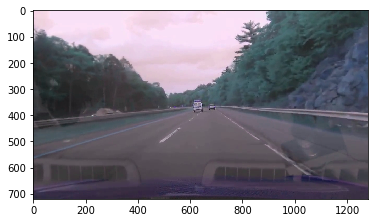

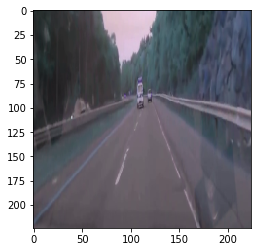

/home/ubuntu/tesla/for_tesla/epochs/epoch10_front.mkv


In [17]:
#将视频解码成预训练网络需要的图片尺寸的图片 
loadVideoAndResize(224, 224)

加载数据

In [4]:

def load_preprocess_training_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer
def load_preprocess_validating_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_val.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.image import ImageDataGenerator
seed = 10
#0213 为interception
#0312 为其它
model_trans = (0, 2, 1, 3)

In [6]:
#这里将输出的转向角度处理成间隔为0.5的数值，这是因为训练数据和测试数据的转向角度都是这样的数据
def nor_output(pre_y):
    pre = pre_y.reshape(1, -1)[0]
    for i, x in enumerate(pre):
        pre[i] = round(x, 4)

    for i,x in enumerate(pre):
        if x > 0:
            if (x-math.floor(x))>=0.75:
                pre[i] = int(x) + 1.0
            elif (x-math.floor(x))>=0.25:
                pre[i] = (int(x) + 0.5)
            else:
                pre[i] = int(x)
        else:
            if (x-int(x))<=-0.75:
                pre[i] = int(x) - 1.0
            elif (x-int(x))<=-0.25:
                pre[i] = (int(x) - 0.5)
            else:
                pre[i] = int(x)
    return pre

In [30]:
#简单模型
def simple_model_1(time_len=1):
    ch, row, col = 3, 64, 64  # camera format
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
  #  model.add(Lambda(lambda x: x,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(128, 5, 5, subsample=(2, 2), border_mode="same"))
    
    model.add(Flatten())
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))
#  model.add(Lambda(nor_output_1))
    sgd = optimizers.SGD(lr=0.00003, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)

      

    return model

In [15]:
#inceptionV3_model 算法
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
def inceptionV3_model(time_len=1):
    base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#    x = Dense(1024)(x)
    x = Dropout(.5)(x)
  #  x = Dense(1, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1)(x)

# this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    for i, layer in enumerate(base_model.layers):
        print(i, layer.name)

    for layer in model.layers[:113]:
        layer.trainable = True
    for layer in model.layers[113:]:
        layer.trainable = True

    sgd = optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)

    return model

In [37]:
from keras.applications.vgg19 import VGG19
import numpy as np

def vgg19_model(time_len=1):
    #224 * 224
    base_model = VGG19(weights='imagenet',include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = Dropout(.5)(x)
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    
    sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    for i, layer in enumerate(base_model.layers):
        print(i, layer.name)
        
    for layer in model.layers[:12]:
        layer.trainable = False
    for layer in model.layers[12:]:
        layer.trainable = True
    return model

In [106]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

def restNet_model(time_len=1):
    #224 * 224
    base_model = ResNet50(weights='imagenet')

    x = base_model.output
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    
    sgd = optimizers.SGD(lr=0.0003, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    for i, layer in enumerate(base_model.layers):
        print(i, layer.name)
        
    for layer in model.layers[:74]:
        layer.trainable = False
    for layer in model.layers[74:]:
        layer.trainable = True
    return model

In [8]:
batch_size = 32
epoches = 10

In [22]:
#训练模型
from sklearn.metrics import mean_squared_error, r2_score
from keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt
import math
from decimal import Decimal
def train_model(video_list, model_func, resize_w, resize_h, ifSave = False, test_img=None, test_y=None):
    model = model_func()
    
    val_acc = []
    test_acc = []
    for epoch_idx in range(0, epoches):
        
        x_val = np.array([])
        y_val = []
        for video_idx in range(1, len(video_list) + 1):
            x_train, y_train = load_preprocess_training_batch(video_idx, resize_w, resize_h)
            x_train = np.array(x_train).transpose(model_trans)
            print(model_trans)
            #随机打乱数据，取10%的训练数据做验证集
            img_list_train, img_list_val, steer_list_train, steer_list_val = train_test_split(x_train, np.array(y_train), test_size=0.1, random_state=10) 
            datagen = ImageDataGenerator(
              #      featurewise_center=True,
                    preprocessing_function=preprocess_input
              #      featurewise_std_normalization=True                  
                    )
            datagen.fit(img_list_train)
            model.fit_generator(datagen.flow(img_list_train, steer_list_train, batch_size=batch_size),
                    steps_per_epoch=int(len(steer_list_train) / batch_size) + 1, epochs=1)
            
    #        model.fit(img_list_train, steer_list_train, nb_epoch = 1, batch_size = batch_size)
            if x_val.shape == np.array([]).shape:
                x_val = img_list_val
                y_val = list(steer_list_val)
            else:
                x_val = np.vstack((x_val, img_list_val))
                y_val.extend(list(steer_list_val))
        val_acc.append(test_model(model, x_val, y_val))
        test_acc.append(test_model(model, test_img, test_y, ifShow = True))
    if ifSave == True:
        utils.save_model(model)
        
    plt.plot(val_acc,color='b', label='val_accuracy')
    plt.plot(test_acc, color='g', label='test_accuracy')
    plt.legend()
    plt.show()
    return model

In [10]:
#测试模型
def test_model(model, img_list_val, y_val, ifShow=False):
    pre = model.predict(img_list_val)
    pre = nor_output(pre)
  #  print (pre)
    score = r2_score(y_val, pre)
    print("score: %.2f " % (score))
    

    if type(y_val) != np.array:
        y_val = np.array(y_val)
    y_val = y_val.reshape(len(list(y_val)), 1)    
    y_val = y_val.reshape(1, -1)[0]
    x = np.arange(1, len(y_val) + 1)
    y = y_val  - pre ;

    if ifShow==True:
        plt.plot(x, abs(y) , marker = '.', color = 'b', label = 'steer bias',linewidth=0.1)
        plt.legend()
        plt.show()
    return score

In [20]:
res_w = 224
res_h = 224
x_test, y_test = load_preprocess_training_batch(10, res_w, res_h)   
x_test = np.array(x_test).transpose(model_trans)

训练全部视频

In [ ]:
训练简单网络，反复修改了学习率，准确率在验证集上总是稳步上升，但是测试集上总是很快上升到0.3到0.6之间的数值后，慢慢就下降了。

/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same", strides=(2, 2))`
/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same", strides=(2, 2))`
/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same", strides=(2, 2))`
/opt/anaconda3/lib/python3.5/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


(0, 3, 1, 2)
Epoch 1/1
1350/1350 [==============================] - 0s - loss: 11.2157     
(0, 3, 1, 2)
Epoch 1/1
3510/3510 [==============================] - 0s - loss: 3.8602     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 7.9480     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 72.7262     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 16.9576     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 43.4292     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 8.6485     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 22.8032     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 1.8776     
score: 0.04 
score: -0.12 


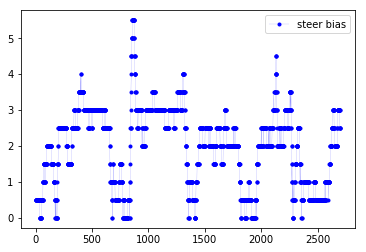

(0, 3, 1, 2)
Epoch 1/1
1350/1350 [==============================] - 0s - loss: 10.9236     
(0, 3, 1, 2)
Epoch 1/1
3510/3510 [==============================] - 0s - loss: 3.5031     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 7.6041     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 69.3006     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 16.3956     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 37.3379     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 8.3456     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 21.4586     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 1.4475     
score: 0.13 
score: 0.11 


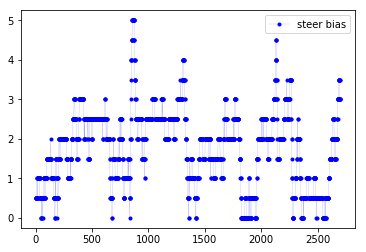

(0, 3, 1, 2)
Epoch 1/1
1350/1350 [==============================] - 0s - loss: 8.5186     
(0, 3, 1, 2)
Epoch 1/1
3510/3510 [==============================] - 0s - loss: 3.0496     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 7.2702     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 62.7149     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 16.3299     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 29.3335     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 6.2630     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 19.7820     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 1.5553     
score: 0.17 
score: 0.36 


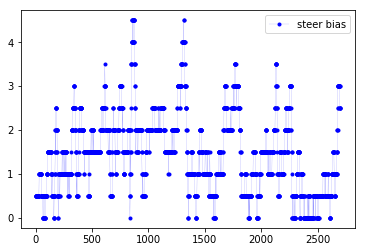

(0, 3, 1, 2)
Epoch 1/1
1350/1350 [==============================] - 0s - loss: 7.0737     
(0, 3, 1, 2)
Epoch 1/1
3510/3510 [==============================] - 0s - loss: 2.9388     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 6.9977     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 54.1530     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 15.7887     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 28.0740     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 5.0354     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 17.5323     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 1.8346     
score: 0.21 
score: 0.46 


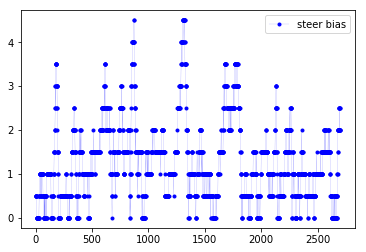

(0, 3, 1, 2)
Epoch 1/1
1350/1350 [==============================] - 0s - loss: 7.5858     
(0, 3, 1, 2)
Epoch 1/1
3510/3510 [==============================] - 0s - loss: 2.8270     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 6.3527     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 43.1013     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 16.1874     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 26.4909     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 4.2655     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 15.3800     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 2.5108     
score: 0.21 
score: 0.39 


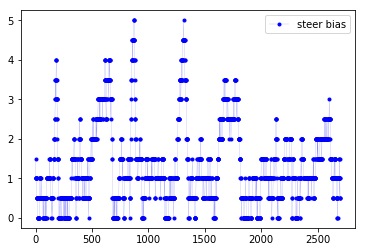

(0, 3, 1, 2)
Epoch 1/1
1350/1350 [==============================] - 0s - loss: 8.9083     
(0, 3, 1, 2)
Epoch 1/1
3510/3510 [==============================] - 0s - loss: 2.9347     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 5.9713     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 33.0493     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 17.4205     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 23.6593     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 3.9986     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 13.3604     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 2.9460     
score: 0.23 
score: 0.41 


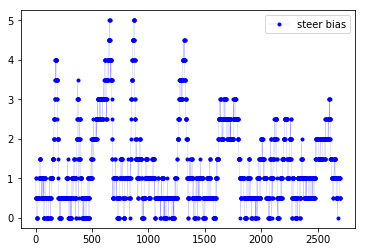

(0, 3, 1, 2)
Epoch 1/1
1350/1350 [==============================] - 0s - loss: 9.5558     
(0, 3, 1, 2)
Epoch 1/1
3510/3510 [==============================] - 0s - loss: 3.0242     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 5.8410     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 25.8611     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 17.3363     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 19.2769     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 3.5344     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 12.4195     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 3.1271     
score: 0.35 
score: 0.23 


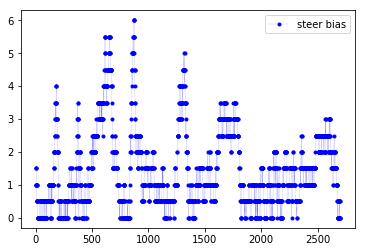

(0, 3, 1, 2)
Epoch 1/1
1350/1350 [==============================] - 0s - loss: 9.3233     
(0, 3, 1, 2)
Epoch 1/1
3510/3510 [==============================] - 0s - loss: 3.1605     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 5.6196     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 20.9587     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 16.6355     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 17.9843     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 3.4585     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 11.2299     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 2.7829     
score: 0.38 
score: 0.15 


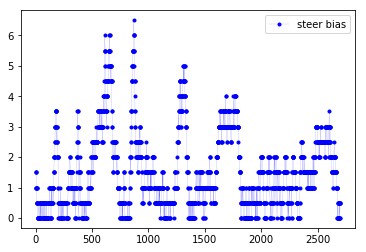

(0, 3, 1, 2)
Epoch 1/1
1350/1350 [==============================] - 0s - loss: 9.3747     
(0, 3, 1, 2)
Epoch 1/1
3510/3510 [==============================] - 0s - loss: 3.1713     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 5.1800     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 18.4440     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 15.8981     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 16.1023     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 3.3355     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 10.0875     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 2.8761     
score: 0.43 
score: 0.03 


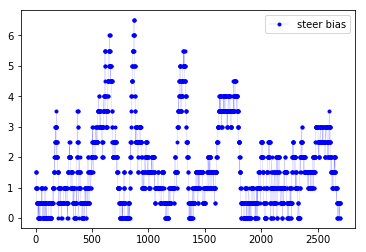

(0, 3, 1, 2)
Epoch 1/1
1350/1350 [==============================] - 0s - loss: 9.0249     
(0, 3, 1, 2)
Epoch 1/1
3510/3510 [==============================] - 0s - loss: 2.9635     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 4.8353     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 16.8167     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 15.1697     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 14.0007     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 3.0718     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 9.4350     
(0, 3, 1, 2)
Epoch 1/1
2430/2430 [==============================] - 0s - loss: 2.7720     
score: 0.49 
score: 0.03 


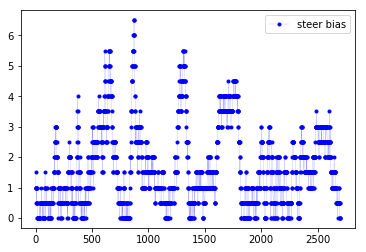

Model saved


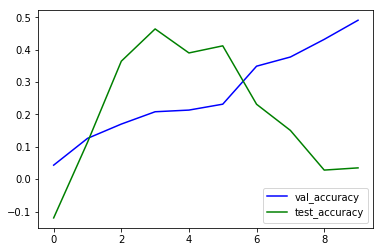

In [31]:

model_all = train_model(range(1, 10),  simple_model_1, res_w, res_h, ifSave = True, test_img = x_test, test_y = y_test)


In [ ]:
训练inceptionV3算法模型，修改的参数一个是学习率，另一个是算法从哪个层开始训练，之前的权重保留，但是测试集上的准确率都不好，
稍微上升了然后就不增或者慢慢下降了，最多到了0.5.

0 input_12
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 flatten
23 fc1
24 fc2
25 predictions
(0, 2, 1, 3)


/home/ubuntu/anaconda/lib/python3.6/site-packages/keras/engine/training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
43/43 [==============================] - 33s 762ms/step - loss: 10.4444
(0, 2, 1, 3)
Epoch 1/1
110/110 [==============================] - 74s 677ms/step - loss: 3.7983
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 683ms/step - loss: 7.5252
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 684ms/step - loss: 68.8738
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 685ms/step - loss: 13.9867
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 685ms/step - loss: 32.9309
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 684ms/step - loss: 8.8020
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 685ms/step - loss: 21.9179
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 684ms/step - loss: 2.4282
score: 0.02 
score: -0.52 


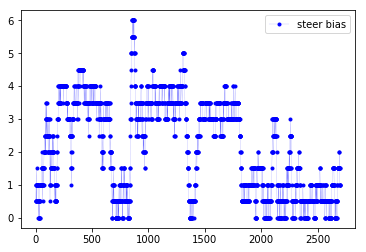

(0, 2, 1, 3)
Epoch 1/1
43/43 [==============================] - 29s 672ms/step - loss: 9.9090
(0, 2, 1, 3)
Epoch 1/1
110/110 [==============================] - 75s 683ms/step - loss: 3.7521
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 685ms/step - loss: 6.8311
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 685ms/step - loss: 65.0355
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 685ms/step - loss: 14.4346
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 683ms/step - loss: 32.5092
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 685ms/step - loss: 7.9513
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 685ms/step - loss: 20.7486
(0, 2, 1, 3)
Epoch 1/1
76/76 [==============================] - 52s 685ms/step - loss: 2.4512
score: -0.03 
score: -0.72 


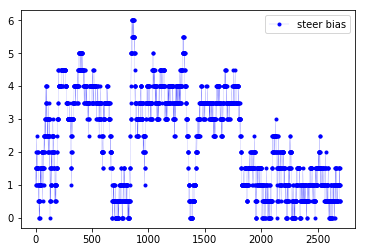

(0, 2, 1, 3)
Epoch 1/1
 3/43 [=>............................] - ETA: 27s - loss: 9.9648

In [ ]:
model_all = train_model(range(1, 10),  vgg19_model, res_w, res_h, ifSave = True, test_img = x_test, test_y = y_test)

#test_model(model_all, x_test, y_test)

实验了一下办监督学习，结果也不好

In [47]:
def inception_v3_semi_super_model():
    base_model = InceptionV3(weights='imagenet', include_top=True)
    model = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)
    return model

In [53]:
def get_featurn_h5_path(video_idx):
    return utils.join_dir(params.data_dir, 'epoch{:0>2}_feature.h5').format(video_idx)
def get_y_h5_path(video_idx):
    return utils.join_dir(params.data_dir, 'epoch{:0>2}_y.h5').format(video_idx)
def save_feature_and_y_h5(model, video_list):
    for v_idx in video_list:
        features = []
        x_test, y_test = load_preprocess_training_batch(v_idx, res_w, res_h)   
        x_test = np.array(x_test).transpose(0, 1, 2, 3)
        for x in x_test:            
            x = np.expand_dims(x, axis=0)
          #  print (x)
         #   x = preprocess_input(x)
         #   x /= 127.5
         #   x -= 1.
            feature = model.predict(x)
            flat = feature.flatten()
            if v_idx== 1:
                print(flat)
            features.append(flat)
            
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_feature.h5').format(v_idx)
        y_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_y.h5').format(v_idx)

        h5f_data = h5py.File(vid_path, 'w')
        h5f_data.create_dataset('dataset_1', data=np.array(features))
        h5f_data.close()
        
        h5y_data = h5py.File(y_path, 'w')
        h5y_data.create_dataset('dataset_1', data=np.array(y_test))
        h5y_data.close()
        print(vid_path)
        
def get_feature_and_y(video_idx):
    h5f_data  = h5py.File(get_featurn_h5_path(video_idx), 'r')
    h5f_y = h5py.File(get_y_h5_path(video_idx), 'r')

    features = h5f_data['dataset_1']
    ys = h5f_y['dataset_1']

    features = np.array(features)
    ys   = np.array(ys)

    h5f_data.close()
    h5f_y.close()
    return features, ys

In [102]:
import h5py
import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


from sklearn import tree
def performance_metric(y_true, y_predict):
    
    score = r2_score(y_true, y_predict)

    return score
def train_semi_super_model(video_list, cnn_model_func, resize_w, resize_h, ifSave = False, test_video=None, if_save_feature=True):
    cnn_model = cnn_model_func()
    if if_save_feature == True:
        save_feature_and_y_h5(cnn_model, video_list)
        if test_video != None:
            save_feature_and_y_h5(cnn_model, [test_video])
    
    val_acc = []
    test_acc = []
    
    
    x_train = np.array([])
    y_train = []
    x_val = np.array([])
    y_val = []
    print("start load h5")
    for video_idx in range(1, len(video_list) + 1):
            
        features, ys = get_feature_and_y(video_idx)
            
        #随机打乱数据，取10%的训练数据做验证集
        f_list_train, f_list_val, steer_list_train, steer_list_val = train_test_split(features, np.array(ys), test_size=0.1, random_state=10) 
            
        if x_val.shape == np.array([]).shape:
            x_train = f_list_train
            y_train = list(steer_list_train)
            x_val = f_list_val
            y_val = list(steer_list_val)
        else:
            x_train = np.vstack((x_train, f_list_train))
            y_train.extend(list(steer_list_train))
            x_val = np.vstack((x_val, f_list_val))
            y_val.extend(list(steer_list_val))
        print(len(y_val))
        
    cross_validator = KFold(n_splits=10)
    regressor = tree.DecisionTreeRegressor()
    params = {'max_depth':[100,200,300,400,500,600,700,800,900,10000]}
    grid =  GridSearchCV(regressor,param_grid=params,scoring=make_scorer(performance_metric), cv=cross_validator)

    grid.fit(f_list_train, steer_list_train)
    print (pd.DataFrame(grid.cv_results_))

  #  val_acc.append(test_model(grid.best_estimator_, x_val, y_val))
    if test_video != None:
        test_features, test_ys = get_feature_and_y(test_video)
        test_acc.append(test_model(grid.best_estimator_, test_features, test_ys))
  #  if ifSave == True:
      #  utils.save_model(regressor)
        
 #   plt.plot(val_acc,color='b', label='验证准确率')
  #  plt.plot(test_acc, color='g', label='测试准确率')
 #   plt.show()
 #   return model

/Users/apple/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5


/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  This is separate from the ipykernel package so we can avoid doing imports until


start load h5
150
540
810
1080
1350
1620
1890
2160
2430
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       5.655519         0.007093         0.811431               1.0   
1       5.516026         0.001803         0.798067               1.0   
2       5.503612         0.000903         0.822081               1.0   
3       5.444082         0.000887         0.804631               1.0   
4       5.470009         0.000802         0.803466               1.0   
5       5.547984         0.000866         0.823357               1.0   
6       5.452721         0.000827         0.797042               1.0   
7       5.452158         0.000915         0.809544               1.0   
8       5.485898         0.000906         0.812880               1.0   
9       5.451528         0.000904         0.811314               1.0   

  param_max_depth                params  rank_test_score  split0_test_score  \
0             100    {'max_depth': 100}                4           0.824

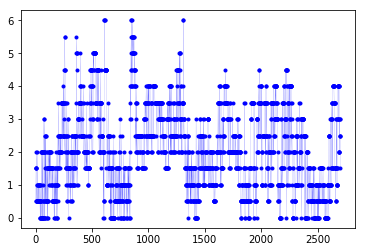

In [103]:
train_semi_super_model(range(1, 10),  inception_v3_semi_super_model, res_w, res_h, ifSave = True, test_video = 10,if_save_feature=False)
